# Pull ITS_LIVE velocities along a glacier centerline

Must have the __its_live__ GitHub code: https://github.com/nasa-jpl/its_live

Requires activated __itslive-notebooks__ environment.

If you have not created this environment, create it with conda.
From the __its_live__ GitHub repository root, run in a terminal:

    cd notebooks
    conda env create -f environment.yml

Activate the environment:

    conda activate itslive-notebooks
    
Then start the jupyter notebook in the active environment:

    jupyter notebook
    
_Last modified by jukesliu@u.boisestate.edu 2022-09-21._

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import xarray
from ordered_set import OrderedSet # pip install ordered-set
from pyproj import Proj # to get UTM coordinates from lat, lon
import cmocean
import fiona

# import additioonal functions
from additional_functions import *
# intialize projections:
TurnerProj = Proj("+proj=utm +zone=7 +hemisphere='N' +ellps=WGS84 +datum=WGS84 +units=m +no_defs") # UTM Zone 7N
psProj = Proj(init='epsg:3413') # Greenland Polar Stereographic projection

# import the velocity widget from ITS LIVE
from velocity_widget import ITSLIVE
velocity_widget = ITSLIVE()

/Users/jukesliu/opt/anaconda3/envs/itslive-notebooks/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


NoneType: None



In [2]:
# install cmocean if not installed
# !pip install cmocean

# 1) Set one point location and the variable of interest (v, vx, vy, va, va_error)

In [3]:
EPSG = '4326'
point_xy = (-139.74, 60.06)
UTMx, UTMy = TurnerProj(point_xy[0], point_xy[1])
psx, psy = psProj(point_xy[0], point_xy[1])
print("Lat/lon:",point_xy)
print("EPSG3413:", psx, psy)
print("UTM7N: ", UTMx, UTMy)
variable = 'v' # vx, vy, v_error

Lat/lon: (-139.74, 60.06)
EPSG3413: -3304871.2608492156 274032.84194428363
UTM7N:  570149.7451277426 6658761.7254312225


In [4]:
# grab time series for that point
[ins3xr, pt_variable, point_tilexy] = velocity_widget.get_timeseries(point_xy, EPSG, variable)

found datacube - elapsed time:       0.03
{'fill-opacity': 0.2621744976502005, 'fill': 'red', 'roi_percent_coverage': 73.78255023497995, 'geometry_epsg': {'type': 'Polygon', 'coordinates': [[[-3400000, 200000], [-3300000, 200000], [-3300000, 300000], [-3400000, 300000], [-3400000, 200000]]]}, 'datacube_exist': 1, 'zarr_url': 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr', 'epsg': 3413}
original xy (-139.74, 60.06) 4326 maps to datacube (-3304871.2608492156, 274032.84194428363)  3413
xarray open - elapsed time:       2.77
time series loaded 33892 points - elapsed time:       3.12


### Select the velocities for that point by sensor

In [5]:
# different satellite sensors
satellites = list(set(ins3xr.satellite_img1.values))
print(satellites)

['2B', '1A', '9.', '1B', '2A', '8.']


In [6]:
# grab SAR data
[mid_dates_SAR, var_SAR, d1_SAR, d2_SAR, sat_SAR] = grab_v_by_sensor(ins3xr, pt_variable, 
                                                            30, # max separation of 30 days
                                                            ['1A','1B']) # SAR sensors
SAR_df = pd.DataFrame(list(zip(mid_dates_SAR, var_SAR, d1_SAR, d2_SAR, sat_SAR)),
                      columns=['mid_date','v','d1','d2','sat'])
SAR_df.head()

,mid_date,v,d1,d2,sat
0,2019-01-14 15:48:37.424842752,NaN,2019-01-08 15:48:37.464079872,2019-01-20 15:48:37.265324032,1A
1,2021-07-02 15:48:53.699193088,NaN,2021-06-26 15:48:53.323300096,2021-07-08 15:48:53.954802688,1A
2,2017-04-02 02:54:50.298477312,NaN,2017-03-27 02:54:50.000769792,2017-04-08 02:54:50.477907968,1A
3,2018-10-04 15:48:39.701758976,NaN,2018-09-22 15:48:39.385136128,2018-10-16 15:48:39.898100992,1A
4,2016-03-14 15:31:50.847436032,NaN,2016-03-02 15:31:50.558352896,2016-03-26 15:31:51.016245248,1A


In [7]:
# grab optical data
[mid_dates_opt, var_opt, d1_opt, d2_opt, sat_opt] = grab_v_by_sensor(ins3xr, pt_variable, 
                                                            30, # max separation of 30 days
                                                            ['8.','9.','2A','2B']) 
optical_df = pd.DataFrame(list(zip(mid_dates_opt, var_opt, d1_opt, d2_opt, sat_opt)),
                      columns=['mid_date','v','d1','d2','sat'])
optical_df.head()

,mid_date,v,d1,d2,sat
0,2014-04-11 20:18:38.560136960,NaN,2014-04-03 20:18:47.000000000,2014-04-19 20:18:30.000000000,8.
1,2014-04-27 20:18:21.560136960,NaN,2014-04-19 20:18:30.000000000,2014-05-05 20:18:13.000000000,8.
2,2014-03-15 20:37:35.560141056,NaN,2014-03-07 20:37:42.000000000,2014-03-23 20:37:29.000000000,8.
3,2017-04-03 20:18:08.560136960,NaN,2017-03-26 20:18:12.000000000,2017-04-11 20:18:04.999999744,8.
4,2021-07-24 20:37:07.546696960,NaN,2021-07-16 20:37:03.224836352,2021-08-01 20:37:11.748274944,8.


### Plot velocity time series at that point:

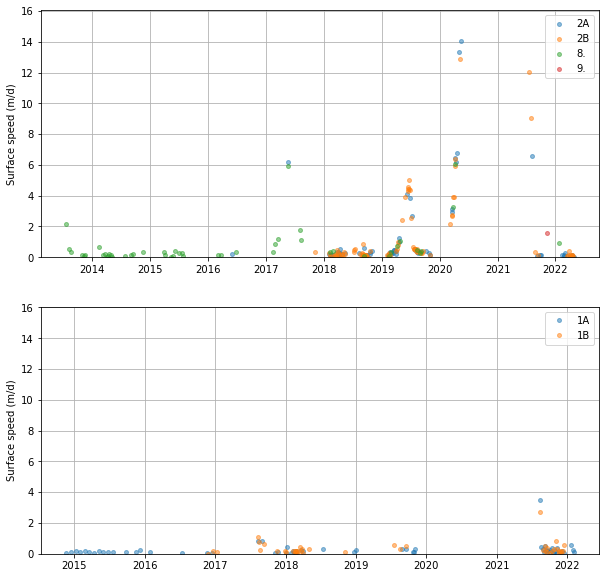

In [10]:
# Plot by sat groups
fig, axs = plt.subplots(2,1,figsize=(10,10))
ax_idx = 0
for df in [optical_df, SAR_df]:
    groups = df.groupby('sat')
    for name, group in groups:
        axs[ax_idx].plot(group.mid_date, mytomd(group.v), marker='o', linestyle='', ms=4, label=name, alpha=0.5)
    axs[ax_idx].legend()
    axs[ax_idx].set_ylabel('Surface speed (m/d)')
    axs[ax_idx].set_ylim(0, np.nanmax(mytomd(np.concatenate([optical_df.v,SAR_df.v])))+2)
    axs[ax_idx].grid()
    ax_idx+=1
    
plt.show()

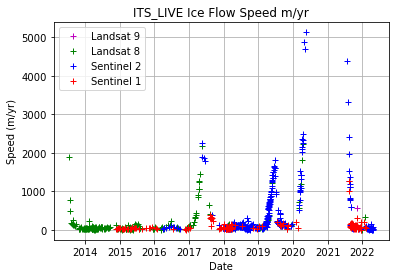

In [11]:
# compare to the ITS_LIVE plot
plot_by_sensor(ins3xr, pt_variable, 150) # max separation of 30 days

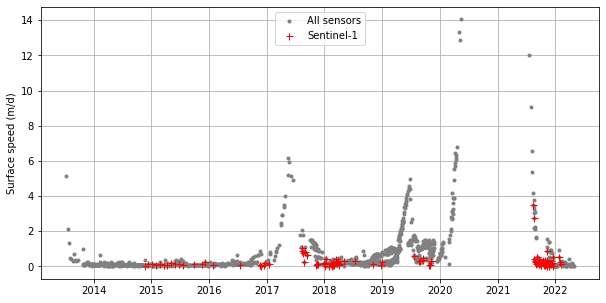

In [14]:
# Plot SAR vs. other
plt.figure(figsize=(10,5))
plt.plot(ins3xr.mid_date, mytomd(pt_variable),'o', color='gray',markersize=3) # All
plt.plot(mid_dates_SAR, mytomd(var_SAR),'r+',markersize=7) # SAR
plt.ylabel('Surface speed (m/d)')
plt.grid()
plt.legend(['All sensors', 'Sentinel-1'],loc='upper center')
plt.show()

In [ ]:
# plt.plot(ins3xr.mid_date, ins3xr.satellite_img1, '.')

# 2) Plot entire map overlapping the point for each mid_date (slow):

In [ ]:
# figpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/its_live_maps/' # path to save figures to

In [ ]:
# for t in ins3xr.mid_date:
#     datestr = str(t.values)[:10]
#     sensorstr = str(ins3xr.satellite_img1[ins3xr.mid_date == t].values[0])
#     titlestr = datestr+', sensor:'+sensorstr
#     print(titlestr)
    
#     # plot the map
#     plt.subplots(1,1)
#     ins3xr.sel(mid_date=t).v.plot(cmap=cmocean.cm.thermal) # can specify xlim, ylim
#     plt.scatter(point_tilexy[0],point_tilexy[1], color='red') # point of interest
#     plt.title(titlestr)
#     plt.savefig(figpath+datestr+'_'+sensorstr+'.png',dpi=200)
#     plt.show()

In [ ]:
# ins3xr

# 3) Grab velocities along centerline

In [ ]:
cline_path = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/centerlines/'
clinefile = 'centerline_n_utm07_250m.shp' # spaced 250 m apart

# open centerline shapefile (points) and grab lat,lon coordinates
f = fiona.open(cline_path+clinefile)
fcoords = []
for feature in f:
    fcoords.append(feature['geometry']['coordinates'])
fcoords

In [ ]:
################################
max_separation = 365 # days
# sensor_list = ['1A','1B'] # toggle SAR images
sensor_list = ['8.','2A','2B'] # toggle optical images
EPSG = '32607' # point coordinate projection
################################

v_err_dfs = []
vx_dfs = []
vy_dfs = []
counter = 0
for point_xy in fcoords:
    lon = point_xy[0]; lat = point_xy[1] # grab the point coodinates
    UTMx, UTMy = TurnerProj(lon, lat) # convert lat lon to UTM

    if counter < len(fcoords)-1: # don't exceed coordinates
        for variable in ["vx","vy","v_error"]: # need to match ins3xr variable names
            [ins3xr, pt_variable, point_tilexy] = velocity_widget.get_timeseries(point_xy, EPSG, variable)
            [mid_dates, var, d1, d2, sat] = grab_v_by_sensor(ins3xr, pt_variable, 
                                                                max_separation, # max separation of 30 days 
                                                                sensor_list) 
            # create columns with UTM and lat/lon coordinates
            lons = np.full(np.size(mid_dates), lon); lats = np.full(np.size(mid_dates), lat)  
            UTMxs = np.full(np.size(mid_dates), UTMx); UTMys = np.full(np.size(mid_dates), UTMy)  

            # enter into dataframe
            df = pd.DataFrame(list(zip(lons, lats, UTMxs, UTMys, mid_dates, d1, d2, var, sat)),
                            columns=['lon','lat','UTMx','UTMy','mid_date','ds1','ds2',variable,'sat'])
            
            # append dataframe
            if np.count_nonzero(~np.isnan(df[variable])) >= len(fcoords)/3: # if at least 1/3 of centerline has data
                if variable == 'vx':
                    vx_dfs.append(df)
                elif variable == 'vy':
                    vy_dfs.append(df)
                elif variable == 'v_error':
                    v_err_dfs.append(df)
        
    counter += 1 # increment counter

In [ ]:
# concatenate all dfs
vx_df = pd.concat(vx_dfs); vx_df.columns=['lon','lat','UTMx','UTMy','mid_date','ds1','ds2','vx','sat']
vy_df = pd.concat(vy_dfs); vy_df.columns=['lon','lat','UTMx','UTMy','mid_date','ds1','ds2','vy','sat']
verror_df = pd.concat(v_err_dfs); verror_df.columns=['lon','lat','UTMx','UTMy','mid_date','ds1','ds2','v_error','sat']

In [ ]:
total_df = verror_df.merge(vy_df.merge(vx_df, 
                       on=['lon','lat','UTMx','UTMy','mid_date','ds1','ds2','sat'],
                       how='inner').drop_duplicates(), 
                           on=['lon','lat','UTMx','UTMy','mid_date','ds1','ds2','sat'],
                           how='inner').drop_duplicates()
# remove time from datetimes
total_df.ds1 = [str(d1)[:10] for d1 in total_df.ds1]
total_df.ds2 = [str(d1)[:10] for d1 in total_df.ds2]
total_df.mid_date = [str(d1)[:10] for d1 in total_df.mid_date]

# reset indexes
total_df = total_df.reset_index(drop=True)
total_df

In [ ]:
total_df.to_csv('ITS_LIVE_vx_vy_optical_centerline_n.csv')

### Calculate distance along glacier centerline and speed values

In [2]:
# # read in the csv file
# csvname = 'ITS_LIVE_vx_vy_optical_centerline_n.csv'
# df = pd.read_csv(csvname, usecols=[1,2,3,4,5,6,7,8,9,10,11],dtype=str)
# df = df.drop_duplicates()
# df

In [3]:
# # Show centerline
# plt.plot(df.lon.astype(float), df.lat.astype(float), 'o-')
# plt.show()

In [4]:
# # Calculate distance along glacier centerline - HAS BUGS, NEED TO FIX
# dist_kms = [] # calculated distance along the centerline
# lats = list(OrderedSet(df.lat))
# lats.sort()

# df = df.sort_values(by='lat') # sort df by lat

# for i in range(0, len(lats)):
#     if i == 0: # first value
#         dist_km = 0
#     elif i < len(lats)-1:
#         lat = lats[i] # grab the lat
#         point_df = df[df.lat == lat] # grab the part of the table for that point

#         # grab the UTM x and y
#         x1 = list(point_df.UTMx.astype(float))[0]; y1 = list(point_df.UTMy.astype(float))[0]

#         # grab the next UTM x and y
#         lat2 = lats[i+1]
#         point_df2 = df[df.lat == lat2] # grab the part of the table for that point
#         x2 =  list(point_df2.UTMx.astype(float))[0]; y2 =  list(point_df2.UTMy.astype(float))[0]
        
#         dist_km = euc_distance(x1,y1,x2,y2)/1000 # calculate distances between points in km
#     dist_kms.append(dist_km) # append to list
    
# dist_from_term = np.cumsum(dist_kms) # make a cumulative sum of distances from terminus
# print(dist_from_term)

# full_dist_list = []
# # now add back into df
# for i in range(0, len(lats)):
#     lat = lats[i]; point_df = df[df.lat == lat] # grab the lat data for that point
#     term_dist = dist_from_term[i] # grab the distance
#     term_dists = np.full(np.size(point_df.lat), term_dist) # create a vector of distances
#     full_dist_list.extend(term_dists) # add them all together
# df['dist_km'] = full_dist_list
# df

In [5]:
# # fill in empty halves - what's going on?
# for idx, row in unique_date_df(sorted_df,'ds1','ds2').iterrows():
#     d1 = row.ds1
#     d2 = row.ds2
#     date_df = sorted_df[(sorted_df.ds1 == d1) & (sorted_df.ds2 == d2)]
    
#     if len(date_df) == 22:
#         continue
# #         print(date_df.dist_km)
#     else:
#         print(len(date_df))
# #         print(date_df.dist_km)

In [ ]:
# # sort the values by date and distance along centerline
# sorted_df = df.sort_values(by=['mid_date','ds1','ds2','dist_km'])
# sorted_df['vmag'] = vector_magnitude(sorted_df.vy.astype(float), sorted_df.vx.astype(float))
# sorted_df

# sorted_df

In [ ]:
# sorted_df.to_csv(csvname) # save the file!